# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


# 1. Importing libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

In [2]:
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

In [3]:
import xgboost as xgb
from xgboost import XGBClassifier

In [4]:
import datetime
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import time
from time import time as tim

In [5]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 1.1 Understanding datasets

In [6]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [7]:
portfolio.shape

(10, 6)

In [8]:
portfolio.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')

In [9]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [10]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [11]:
profile.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income'], dtype='object')

In [12]:
profile.shape

(17000, 5)

In [13]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [14]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [15]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [16]:
transcript.columns

Index(['person', 'event', 'value', 'time'], dtype='object')

In [17]:
copy_portfolio = portfolio.copy()

# 2. Data Cleaning and amendments


### 2.1 Portfolio


In [18]:
channels_full_list = ['email', 'mobile', 'social', 'web']
def transform_channels(channels):
    transform_channel = [1 if channel in channels else 0 for channel in channels_full_list]
    return transform_channel

In [19]:
def amending_portfolio(portfolio=portfolio):
    
    portfolio['offer_id'] = portfolio['id']
    portfolio = portfolio.join(pd.DataFrame(portfolio['channels'].apply(transform_channels).tolist(), columns=channels_full_list))
    portfolio['duration_hours'] = portfolio['duration'] * 24      # Converting the variable- duration into hours.                        
    portfolio = pd.get_dummies(portfolio, columns=['offer_type'])                         
    portfolio = portfolio.drop(columns=['id', 'duration', 'channels'])
    
    return portfolio

df_portfolio_v2 = amending_portfolio()

In [20]:
df_portfolio_v2

,reward,difficulty,offer_id,email,mobile,social,web,duration_hours,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,168,True,False,False
1,10,10,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,120,True,False,False
2,0,0,3f207df678b143eea3cee63160fa8bed,1,1,0,1,96,False,False,True
3,5,5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,168,True,False,False
4,5,20,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,240,False,True,False
5,3,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,168,False,True,False
6,2,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,240,False,True,False
7,0,0,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,72,False,False,True
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,120,True,False,False
9,2,10,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,168,False,True,False


In [21]:
df_portfolio_v2.columns

Index(['reward', 'difficulty', 'offer_id', 'email', 'mobile', 'social', 'web',
       'duration_hours', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational'],
      dtype='object')

### 2.2 Profile 

In [22]:
def amending_profile(df_1=profile):
    df_1['became_member_on'] = pd.to_datetime(df_1['became_member_on'], format='%Y%m%d')
    df_1['year'] = df_1['became_member_on'].dt.year
    df_1['weekday_membership'] = df_1['became_member_on'].dt.weekday
    
    df_1 = pd.get_dummies(profile, columns=['gender', 'year'], prefix=['gender', 'became_member_on'])
    df_1.drop('became_member_on', axis=1, inplace=True)

    return df_1

df_profile_v2 = amending_profile()

In [23]:
df_profile_v2

,age,id,income,weekday_membership,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018
0,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,6,False,False,False,False,False,False,False,True,False
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,5,True,False,False,False,False,False,False,True,False
2,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,3,False,False,False,False,False,False,False,False,True
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,True,False,False,False,False,False,False,True,False
4,118,a03223e636434f42ac4c3df47e8bac43,NaN,4,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,45,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,0,True,False,False,False,False,False,False,False,True
16996,61,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,4,False,True,False,False,False,False,False,False,True
16997,49,01d26f638c274aa0b965d24cefe3183f,73000.0,3,False,True,False,False,False,False,False,True,False
16998,83,9dc1421481194dcd9400aec7c9ae6366,50000.0,0,True,False,False,False,False,False,True,False,False


### 2.3 Transcript

In [24]:
df_transcript_v2 = transcript.query("person in @profile['id']")

In [25]:
df_transcript_v2.columns

Index(['person', 'event', 'value', 'time'], dtype='object')

In [26]:
df_transcript_v2

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [27]:
# A new column named offer_id was created, populated with values extracted from the event data. For transaction events, which lacked an offer ID, a placeholder value of "null" was assigned.
def extracting_id_offer(val):
       return (
                val['offer_id']                              # if 'offer_id' exists
                if 'offer_id' in val
                else val['offer id']                         # if 'offer_id' doesn't exist, check for 'offer id'
                     if 'offer id' in val
                     else np.nan 
                )

In [28]:
df_transcript_v2['offer_id'] = df_transcript_v2['value'].apply(extracting_id_offer)
df_transcript_v2

,person,event,value,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,NaN


### 2.4 Combining datasets

In [29]:
df__1a = df_transcript_v2.merge(df_profile_v2, left_on='person', right_on='id', how='left')
df__1b = df__1a.drop('person', axis=1)
df__1b

,event,value,time,offer_id,age,id,income,weekday_membership,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018
0,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,True,False,False,False,False,False,False,True,False
1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,118,a03223e636434f42ac4c3df47e8bac43,NaN,4,False,False,False,False,False,False,False,True,False
2,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,68,e2127556f4f64592b11af22de27a7932,70000.0,3,False,True,False,False,False,False,False,False,True
3,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,118,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,0,False,False,False,False,False,False,False,True,False
4,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,118,68617ca6246f4fbc85e91a2a49552598,NaN,0,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,transaction,{'amount': 1.5899999999999999},714,NaN,66,b3a1272bc9904337b331bf348c3e8c17,47000.0,0,False,True,False,False,False,False,False,False,True
306530,transaction,{'amount': 9.53},714,NaN,52,68213b08d99a4ae1b0dcb72aebd9aa35,62000.0,6,False,True,False,False,False,False,False,False,True
306531,transaction,{'amount': 3.61},714,NaN,63,a00058cf10334a308c68e7631c529907,52000.0,6,True,False,False,True,False,False,False,False,False
306532,transaction,{'amount': 3.5300000000000002},714,NaN,57,76ddbd6576844afe811f1a3c0fbb5bec,40000.0,5,False,True,False,False,False,False,True,False,False


In [30]:
df__2a = df__1b.merge(df_portfolio_v2, on='offer_id', how='left').sort_values(by=['id', 'time'])
df__2b = df__2a.reset_index(drop=True)
df__2b

,event,value,time,offer_id,age,id,income,weekday_membership,gender_F,gender_M,...,reward,difficulty,email,mobile,social,web,duration_hours,offer_type_bogo,offer_type_discount,offer_type_informational
0,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837,33,0009655768c64bdeb2e877511632db8f,72000.0,4,False,True,...,0.0,0.0,1.0,1.0,1.0,0.0,72.0,False,False,True
1,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,5a8bc65990b245e5a138643cd4eb9837,33,0009655768c64bdeb2e877511632db8f,72000.0,4,False,True,...,0.0,0.0,1.0,1.0,1.0,0.0,72.0,False,False,True
2,transaction,{'amount': 22.16},228,NaN,33,0009655768c64bdeb2e877511632db8f,72000.0,4,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},336,3f207df678b143eea3cee63160fa8bed,33,0009655768c64bdeb2e877511632db8f,72000.0,4,False,True,...,0.0,0.0,1.0,1.0,0.0,1.0,96.0,False,False,True
4,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},372,3f207df678b143eea3cee63160fa8bed,33,0009655768c64bdeb2e877511632db8f,72000.0,4,False,True,...,0.0,0.0,1.0,1.0,0.0,1.0,96.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,transaction,{'amount': 14.23},576,NaN,45,ffff82501cea40309d5fdd7edcca4a07,62000.0,4,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,576,2906b810c7d4411798c6938adc9daaa5,45,ffff82501cea40309d5fdd7edcca4a07,62000.0,4,True,False,...,2.0,10.0,1.0,1.0,0.0,1.0,168.0,False,True,False
306531,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},582,2906b810c7d4411798c6938adc9daaa5,45,ffff82501cea40309d5fdd7edcca4a07,62000.0,4,True,False,...,2.0,10.0,1.0,1.0,0.0,1.0,168.0,False,True,False
306532,transaction,{'amount': 10.12},606,NaN,45,ffff82501cea40309d5fdd7edcca4a07,62000.0,4,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
dataframe1 = df__2b.copy()

In [32]:
dataframe1.columns

Index(['event', 'value', 'time', 'offer_id', 'age', 'id', 'income',
       'weekday_membership', 'gender_F', 'gender_M', 'gender_O',
       'became_member_on_2013', 'became_member_on_2014',
       'became_member_on_2015', 'became_member_on_2016',
       'became_member_on_2017', 'became_member_on_2018', 'reward',
       'difficulty', 'email', 'mobile', 'social', 'web', 'duration_hours',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational'],
      dtype='object')

### 2.5 Manupilating the data

In [33]:
cohort2 = dataframe1[dataframe1['id'] ==  dataframe1['id'].unique()[1]].sort_values('time')
cohort2

,event,value,time,offer_id,age,id,income,weekday_membership,gender_F,gender_M,...,reward,difficulty,email,mobile,social,web,duration_hours,offer_type_bogo,offer_type_discount,offer_type_informational
20,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},168,f19421c1d4aa40978ebb69ca19b0e20d,118,00116118485d4dfda04fdbaba9a87b5c,NaN,2,False,False,...,5.0,5.0,1.0,1.0,1.0,1.0,120.0,True,False,False
21,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},216,f19421c1d4aa40978ebb69ca19b0e20d,118,00116118485d4dfda04fdbaba9a87b5c,NaN,2,False,False,...,5.0,5.0,1.0,1.0,1.0,1.0,120.0,True,False,False
22,transaction,{'amount': 0.7000000000000001},294,NaN,118,00116118485d4dfda04fdbaba9a87b5c,NaN,2,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,transaction,{'amount': 0.2},456,NaN,118,00116118485d4dfda04fdbaba9a87b5c,NaN,2,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,transaction,{'amount': 3.19},474,NaN,118,00116118485d4dfda04fdbaba9a87b5c,NaN,2,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},576,f19421c1d4aa40978ebb69ca19b0e20d,118,00116118485d4dfda04fdbaba9a87b5c,NaN,2,False,False,...,5.0,5.0,1.0,1.0,1.0,1.0,120.0,True,False,False
26,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},630,f19421c1d4aa40978ebb69ca19b0e20d,118,00116118485d4dfda04fdbaba9a87b5c,NaN,2,False,False,...,5.0,5.0,1.0,1.0,1.0,1.0,120.0,True,False,False


In [34]:
# "Informational" offer type is advertisement, and there are no "reward" or "difficulty" or "offer completed" event.
# "Informational" is successful when they folllow "offer received" , "offer viewed" , "transaction"
# "BOGO" and "discount" are successfu when they folllow "offer received" , "offer viewed" ,"offer completed" , "transaction"

def evaluate_offer_success(user_df):
    """Evaluates whether offers were successfully completed for a given customer."""
    
    user_success_dict = {}
    offer_success = False  # persists across rows

    for x, y in user_df.iterrows():
        is_successful = 0
        if y.event == 'offer received':
            offer_deadline = y.time + y.duration_hours
            view_event = dataframe1.loc[x + 1]
            followup_event = dataframe1.loc[x + 2]

            if view_event.event == 'offer viewed' and followup_event.time <= offer_deadline:
                if y.offer_type_informational == 1:
                    if followup_event.event == 'transaction':
                        is_successful = 1
                else:
                    if followup_event.event in ['offer completed', 'transaction']:
                        is_successful = 1
                        offer_success = True

        if x not in user_success_dict:
            
            for i in range(3):
                user_success_dict[x+i] = is_successful
                
            if offer_success:
                user_success_dict[x + 3] = is_successful

    return user_success_dict


In [35]:
# Sort once and group
grouped_users = dataframe1.sort_values('time').groupby('id')

# Build success dictionary directly using dict comprehension
dictionary_success = {
    key: value
    for _, user_df in grouped_users
    for key, value in evaluate_offer_success(user_df).items()
}

# Fill 'successful_offer' directly using mapping from the dictionary
dataframe1['successful_offer'] = dataframe1.index.map(dictionary_success)

# Show value counts
print(dataframe1['successful_offer'].value_counts())

successful_offer
0    254091
1     52443
Name: count, dtype: int64


### 2.6 Final data

In [36]:
# Clean and prepare the dataset with updated variable names
dataframe01 = dataframe1.drop(columns=['id', 'offer_id', 'value', 'time', 'event'])
dataframe02 = dataframe01.dropna()
dataframe_final = dataframe02.drop_duplicates(keep='first')

In [37]:
dataframe_final.to_csv(path_or_buf='data/final_data.csv', index=False)

In [38]:
dataframe_final

,age,income,weekday_membership,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,...,difficulty,email,mobile,social,web,duration_hours,offer_type_bogo,offer_type_discount,offer_type_informational,successful_offer
0,33,72000.0,4,False,True,False,False,False,False,False,...,0.0,1.0,1.0,1.0,0.0,72.0,False,False,True,1
3,33,72000.0,4,False,True,False,False,False,False,False,...,0.0,1.0,1.0,0.0,1.0,96.0,False,False,True,0
5,33,72000.0,4,False,True,False,False,False,False,False,...,5.0,1.0,1.0,1.0,1.0,120.0,True,False,False,0
9,33,72000.0,4,False,True,False,False,False,False,False,...,10.0,1.0,1.0,1.0,1.0,240.0,False,True,False,0
14,33,72000.0,4,False,True,False,False,False,False,False,...,10.0,1.0,1.0,0.0,1.0,168.0,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306496,34,34000.0,0,False,True,False,False,False,False,False,...,5.0,1.0,1.0,0.0,1.0,168.0,True,False,False,0
306501,45,62000.0,4,True,False,False,False,False,False,True,...,10.0,1.0,1.0,1.0,1.0,240.0,False,True,False,1
306507,45,62000.0,4,True,False,False,False,False,False,True,...,20.0,1.0,0.0,0.0,1.0,240.0,False,True,False,0
306515,45,62000.0,4,True,False,False,False,False,False,True,...,10.0,1.0,1.0,0.0,1.0,168.0,False,True,False,0


In [39]:
dataframe_final.columns

Index(['age', 'income', 'weekday_membership', 'gender_F', 'gender_M',
       'gender_O', 'became_member_on_2013', 'became_member_on_2014',
       'became_member_on_2015', 'became_member_on_2016',
       'became_member_on_2017', 'became_member_on_2018', 'reward',
       'difficulty', 'email', 'mobile', 'social', 'web', 'duration_hours',
       'offer_type_bogo', 'offer_type_discount', 'offer_type_informational',
       'successful_offer'],
      dtype='object')

In [40]:
dataframe_final.shape

(60110, 23)

In [41]:
dataframe_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60110 entries, 0 to 306524
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       60110 non-null  int64  
 1   income                    60110 non-null  float64
 2   weekday_membership        60110 non-null  int32  
 3   gender_F                  60110 non-null  bool   
 4   gender_M                  60110 non-null  bool   
 5   gender_O                  60110 non-null  bool   
 6   became_member_on_2013     60110 non-null  bool   
 7   became_member_on_2014     60110 non-null  bool   
 8   became_member_on_2015     60110 non-null  bool   
 9   became_member_on_2016     60110 non-null  bool   
 10  became_member_on_2017     60110 non-null  bool   
 11  became_member_on_2018     60110 non-null  bool   
 12  reward                    60110 non-null  float64
 13  difficulty                60110 non-null  float64
 14  email     

In [42]:
dataframe_final.describe

<bound method NDFrame.describe of         age   income  weekday_membership  gender_F  gender_M  gender_O  \
0        33  72000.0                   4     False      True     False   
3        33  72000.0                   4     False      True     False   
5        33  72000.0                   4     False      True     False   
9        33  72000.0                   4     False      True     False   
14       33  72000.0                   4     False      True     False   
...     ...      ...                 ...       ...       ...       ...   
306496   34  34000.0                   0     False      True     False   
306501   45  62000.0                   4      True     False     False   
306507   45  62000.0                   4      True     False     False   
306515   45  62000.0                   4      True     False     False   
306524   45  62000.0                   4      True     False     False   

        became_member_on_2013  became_member_on_2014  became_member_on_2015  

# 3. Data Analysis

## 3.1 Creating data for analysis

In [43]:
def preparing_data(input_df, portfolio_df):
    # Drop unnecessary columns
    df_no_extra_cols = input_df.drop(columns=['value', 'time', 'event'])

    # Remove rows with missing values
    df_no_missing = df_no_extra_cols.dropna()

    # Drop duplicate rows
    df_unique = df_no_missing.drop_duplicates(keep='first')

    # Merge with portfolio data
    df_merged = df_unique.merge(portfolio_df, on='offer_id', how='inner')

    # Drop redundant columns from merge
    df_trimmed = df_merged.drop(columns=['difficulty_x', 'reward_x'])

    # Rename columns for clarity
    final_df = df_trimmed.rename(columns={
        'difficulty_y': 'difficulty',
        'reward_y': 'reward'
    })

    return final_df

copy_portfolio = copy_portfolio.rename(columns={'id': 'offer_id'})
dataframe_analy = preparing_data(dataframe1, copy_portfolio)

In [44]:
dataframe_analy.to_csv(path_or_buf='data/analysis_data_final.csv', index=False)

In [45]:
dataframe_analy.columns

Index(['offer_id', 'age', 'id', 'income', 'weekday_membership', 'gender_F',
       'gender_M', 'gender_O', 'became_member_on_2013',
       'became_member_on_2014', 'became_member_on_2015',
       'became_member_on_2016', 'became_member_on_2017',
       'became_member_on_2018', 'email', 'mobile', 'social', 'web',
       'duration_hours', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'successful_offer', 'reward', 'channels',
       'difficulty', 'duration', 'offer_type'],
      dtype='object')

In [46]:
dataframe_analy

,offer_id,age,id,income,weekday_membership,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,...,duration_hours,offer_type_bogo,offer_type_discount,offer_type_informational,successful_offer,reward,channels,difficulty,duration,offer_type
0,5a8bc65990b245e5a138643cd4eb9837,33,0009655768c64bdeb2e877511632db8f,72000.0,4,False,True,False,False,False,...,72.0,False,False,True,1,0,"[email, mobile, social]",0,3,informational
1,5a8bc65990b245e5a138643cd4eb9837,40,0011e0d4e6b944f998e987f904e8c1e5,57000.0,1,False,False,True,False,False,...,72.0,False,False,True,0,0,"[email, mobile, social]",0,3,informational
2,5a8bc65990b245e5a138643cd4eb9837,59,0020c2b971eb4e9188eac86d93036a77,90000.0,4,True,False,False,False,False,...,72.0,False,False,True,0,0,"[email, mobile, social]",0,3,informational
3,5a8bc65990b245e5a138643cd4eb9837,24,0020ccbbb6d84e358d3414a3ff76cffd,60000.0,4,True,False,False,False,False,...,72.0,False,False,True,0,0,"[email, mobile, social]",0,3,informational
4,5a8bc65990b245e5a138643cd4eb9837,26,003d66b6608740288d6cc97a6903f4f0,73000.0,2,True,False,False,False,False,...,72.0,False,False,True,1,0,"[email, mobile, social]",0,3,informational
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60679,4d5c57ea9a6940dd891ad53e9dbe8da0,67,fff0f0aac6c547b9b263080f09a5586a,80000.0,3,False,True,False,False,False,...,120.0,True,False,False,0,10,"[web, email, mobile, social]",10,5,bogo
60680,4d5c57ea9a6940dd891ad53e9dbe8da0,59,fff29fb549084123bd046dbc5ceb4faa,93000.0,3,True,False,False,False,False,...,120.0,True,False,False,0,10,"[web, email, mobile, social]",10,5,bogo
60681,4d5c57ea9a6940dd891ad53e9dbe8da0,71,fff7576017104bcc8677a8d63322b5e1,73000.0,1,False,True,False,False,False,...,120.0,True,False,False,1,10,"[web, email, mobile, social]",10,5,bogo
60682,4d5c57ea9a6940dd891ad53e9dbe8da0,71,fff7576017104bcc8677a8d63322b5e1,73000.0,1,False,True,False,False,False,...,120.0,True,False,False,0,10,"[web, email, mobile, social]",10,5,bogo


## 3.2 Functions for Distribution and Probability of offer success 

In [47]:
successful_offer_perc = len(dataframe_final.query("successful_offer == 1")) / len(dataframe_final)
print("Offer success is {:.2f}%.".format(successful_offer_perc * 100))

Offer success is 21.09%.


In [48]:
def draw_annotated_bar_chart(data1, chart_title, x_axis_label, y_axis_label, chart_size=(10, 5)):
    """
    Draws a bar chart with annotations above each bar.

    Args:
        data1 (pd.Series): Data to be plotted.
        chart_title (str): Title of the chart.
        x_axis_label (str): Label for the x-axis.
        y_axis_label (str): Label for the y-axis.
        chart_size (tuple): Size of the chart (width, height).

    Returns:
        None
    """
    bar_axis = data1.plot.bar(figsize=chart_size)
    bar_axis.set_title(chart_title)
    bar_axis.set_xlabel(x_axis_label)
    bar_axis.set_ylabel(y_axis_label)
    
    # Set x-axis label rotation to 0
    bar_axis.set_xticklabels(bar_axis.get_xticklabels(), rotation=0)

    # Annotate each bar with its height
    for bar in bar_axis.patches:
        bar_height = bar.get_height()
        bar_axis.annotate(
            f'{int(bar_height)}',
            xy=(bar.get_x() + bar.get_width() / 2, bar_height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center',
            va='bottom',
            fontsize=8
        )

In [49]:
def visualize_success_probability(dataframe, category, category_label, x_label=None, color_scheme="Purples"):
    """Visualize the average success rate of projects based on a given categorical attribute."""
    new_figure, new_axis = plt.subplots(figsize=(10, 5))  # Changed names to new_figure and new_axis

    # Calculate mean success rate per category
    success_rates = dataframe.groupby(category)['successful_offer'].mean().reset_index()
    success_rates.rename(columns={'successful_offer': 'Success Rate'}, inplace=True)

    # Create bar plot
    bar_plot = sns.barplot(x=category, y='Success Rate', data=success_rates, palette=color_scheme)
    plt.xticks(rotation=0)

    # Add average success rate line
    new_axis.axhline(y=successful_offer_perc, color='black', linestyle='--')
    bar_plot.text(0, successful_offer_perc + 0.003, "Average Success Rate", 
                  ha='left', fontsize='medium', color='black')

    # Set plot titles and labels
    new_axis.set_title(f'Success Rate by {category_label}', fontsize=20)
    xlabel = x_label.capitalize() if x_label else category_label.capitalize()
    new_axis.set_xlabel(xlabel, fontsize=15)
    new_axis.set_ylabel("Success Rate (%)", fontsize=15)

## 3.3 Analysis 

### 3.3.1 Age

In [50]:
def age_interval(age):
    """Categorize age into custom intervals."""
    if age <= 18: return '1) <=18'
    if age <= 30: return '2) 18-30'
    if age <= 45: return '3) 31-45'
    if age <= 60: return '4) 46-60'
    if age <= 75: return '5) 61-75'
    return '6) 75+'


dataframe_analy['age_interval'] = dataframe_analy['age'].apply(age_interval)
age_data = dataframe_analy.groupby('age_interval')['id'].count()
age_data

age_interval
1) <=18       291
2) 18-30     6838
3) 31-45    10944
4) 46-60    20120
5) 61-75    15779
6) 75+       6712
Name: id, dtype: int64

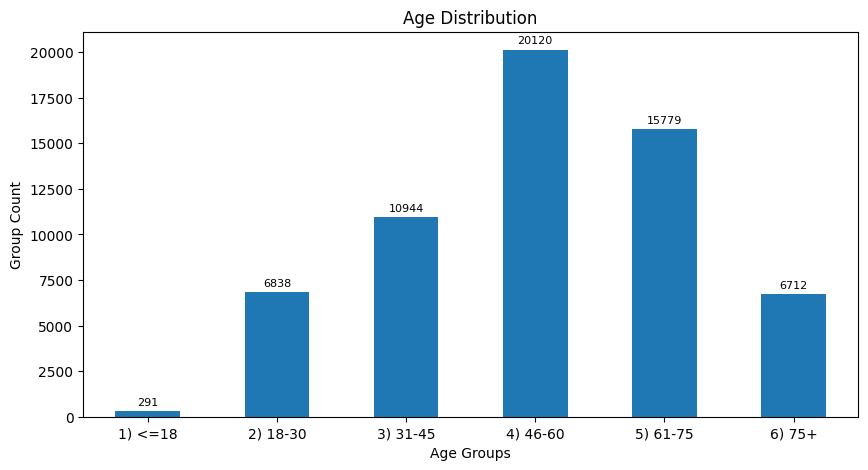

In [51]:
draw_annotated_bar_chart(age_data, 'Age Distribution','Age Groups', 'Group Count')

/tmp/ipykernel_113/4017035685.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=category, y='Success Rate', data=success_rates, palette=color_scheme)


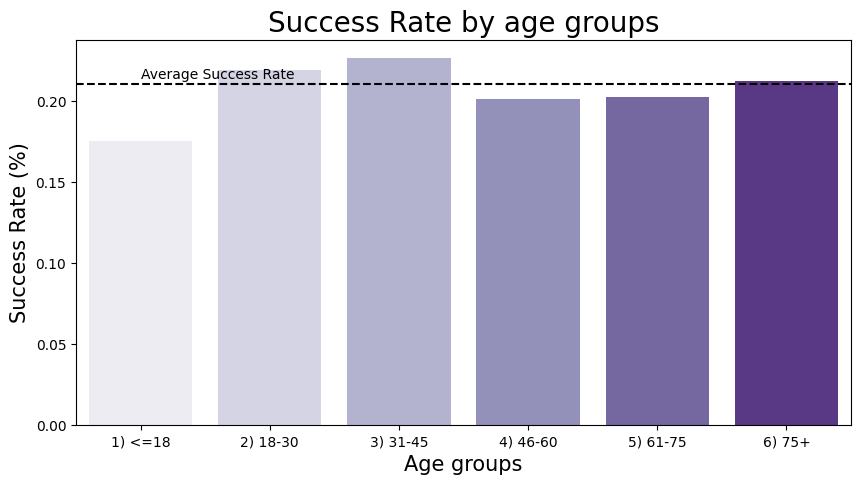

In [52]:
visualize_success_probability(dataframe=dataframe_analy, category='age_interval', category_label='age groups')

### 3.3.2 Income 

In [53]:
def income_interval(income):
    """Categorize income into custom intervals."""
    income = income / 1000
    if income < 40: return '1) <40k'
    if income < 50: return '2) 40k-50k'
    if income < 60: return '3) 50k-60k'
    if income < 70: return '4) 60k-70k'
    if income < 80: return '5) 70k-80k'
    if income < 90: return '6) 80k-90k'
    if income < 100: return '7) 90k-100k'
    if income >= 100: return '8) 100k+' 

dataframe_analy['income_interval'] = dataframe_analy['income'].apply(income_interval)
income_data = dataframe_analy.groupby('income_interval')['id'].count()
income_data

income_interval
1) <40k         8057
2) 40k-50k      7585
3) 50k-60k     11140
4) 60k-70k      9596
5) 70k-80k      9438
6) 80k-90k      5677
7) 90k-100k     4834
8) 100k+        4357
Name: id, dtype: int64

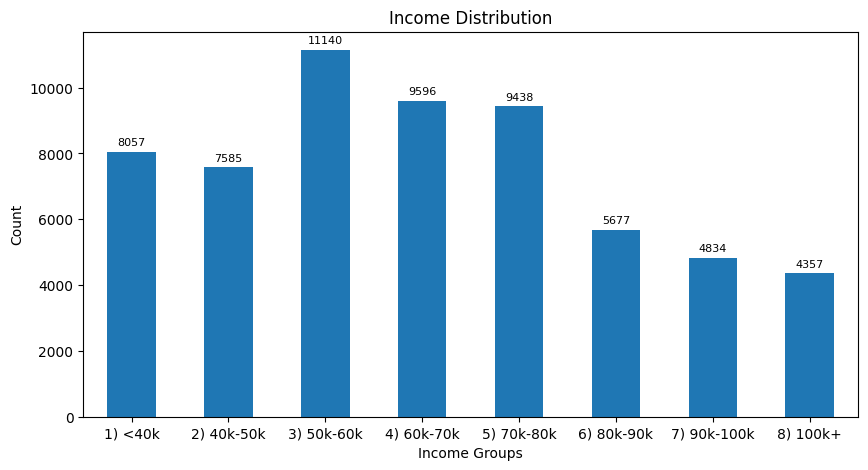

In [54]:
draw_annotated_bar_chart(income_data, 'Income Distribution','Income Groups', 'Count')

/tmp/ipykernel_113/4017035685.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=category, y='Success Rate', data=success_rates, palette=color_scheme)


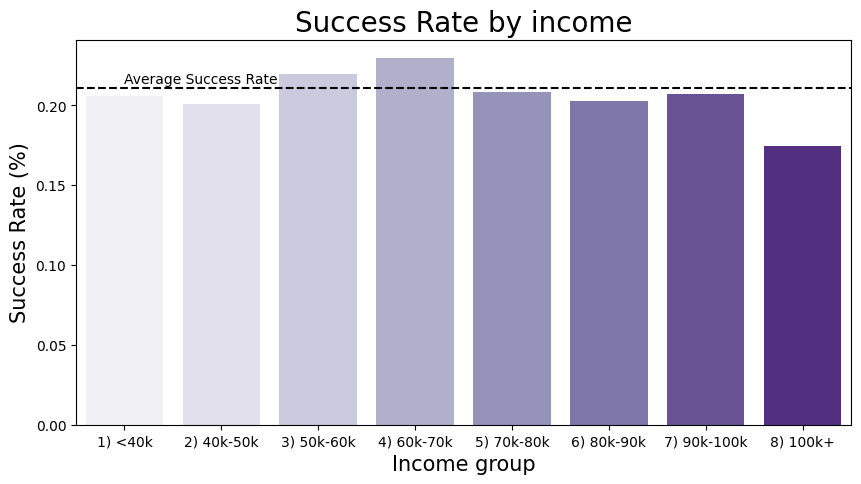

In [55]:
visualize_success_probability( dataframe=dataframe_analy, category='income_interval', category_label='income', x_label='income group')

### 3.3.3 Gender

In [56]:
# Define conditions and choices
conditions = [
    dataframe_analy['gender_M'] == True,
    dataframe_analy['gender_F'] == True,
    dataframe_analy['gender_O'] == True
]

choices = ['M', 'F', 'O']

# Apply logic
dataframe_analy['gender_updated'] = np.select(conditions, choices, default=None)
dataframe_analy['gender_updated']

0        M
1        O
2        F
3        F
4        F
        ..
60679    M
60680    F
60681    M
60682    M
60683    M
Name: gender_updated, Length: 60684, dtype: object

In [57]:
gender_data = dataframe_analy.groupby('gender_updated')['id'].count()
gender_data

gender_updated
F    24958
M    34882
O      844
Name: id, dtype: int64

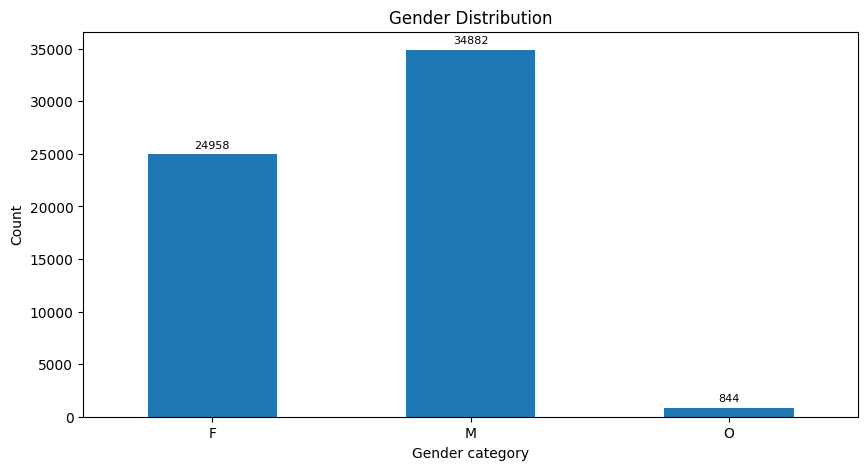

In [58]:
draw_annotated_bar_chart(gender_data,'Gender Distribution','Gender category', 'Count')

/tmp/ipykernel_113/4017035685.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=category, y='Success Rate', data=success_rates, palette=color_scheme)


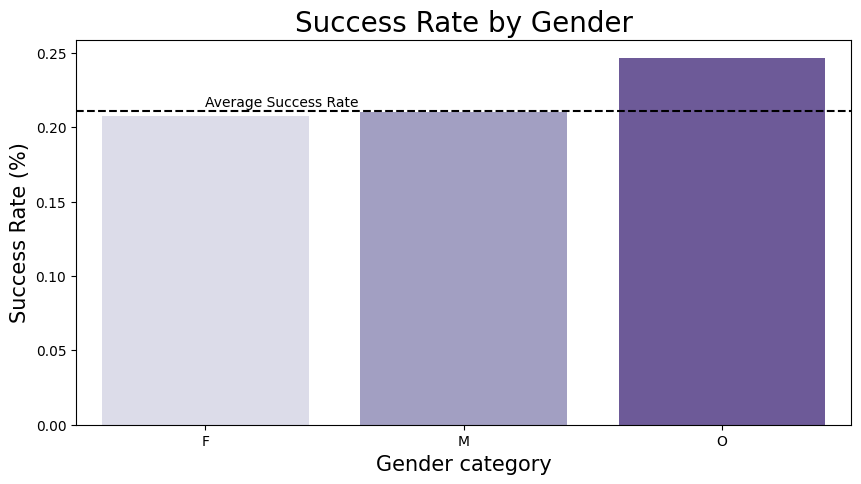

In [59]:
visualize_success_probability(dataframe=dataframe_analy, category='gender_updated', category_label='Gender', x_label='Gender category')

### 3.3.4 Offer type

In [60]:
offer_type_data = dataframe_analy.groupby('offer_type')['id'].count()
offer_type_data

offer_type
bogo             24319
discount         24762
informational    11603
Name: id, dtype: int64

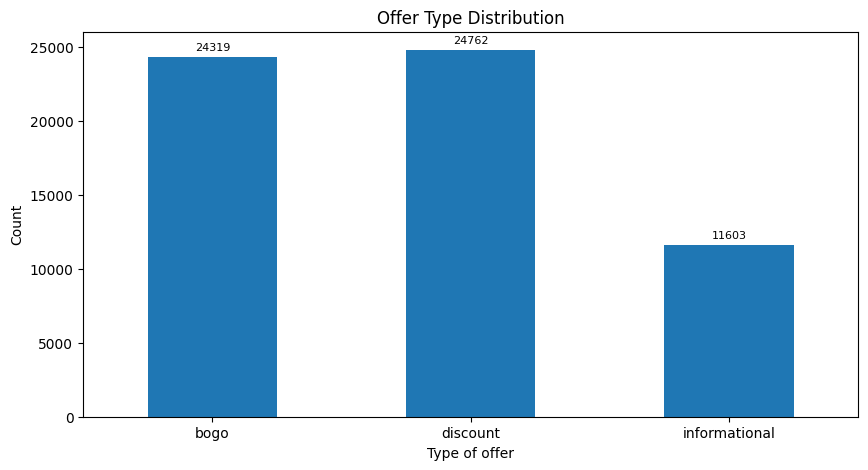

In [61]:
draw_annotated_bar_chart(offer_type_data, 'Offer Type Distribution','Type of offer', 'Count')

/tmp/ipykernel_113/4017035685.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=category, y='Success Rate', data=success_rates, palette=color_scheme)


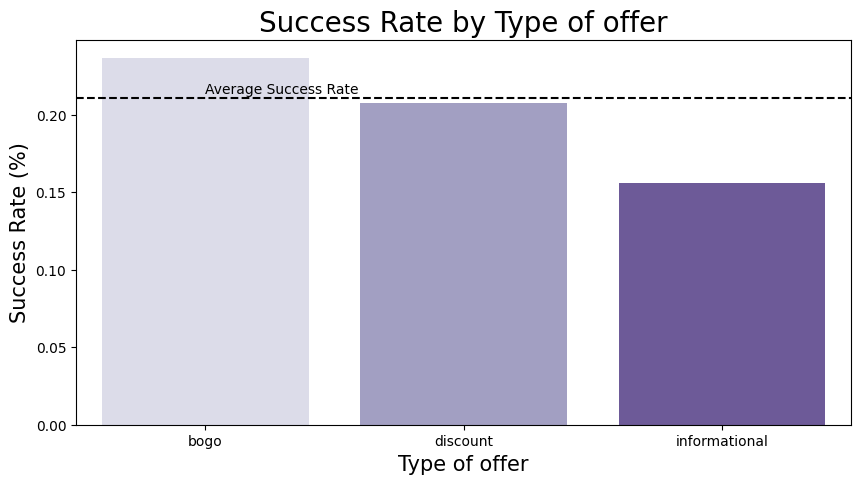

In [62]:
visualize_success_probability(dataframe=dataframe_analy, category='offer_type', category_label='Type of offer', x_label=None)

### 3.3.5  Difficulty (Amount  customer has to spend to complete an offer) and rewards

In [63]:
Difficulty_data = dataframe_analy.groupby('difficulty')['id'].count()
Difficulty_data

difficulty
0     11603
5     12056
7      6321
10    24669
20     6035
Name: id, dtype: int64

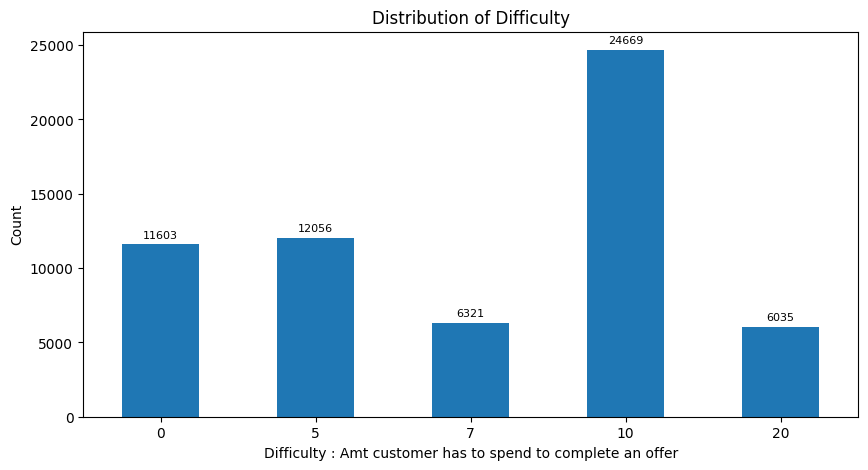

In [64]:
draw_annotated_bar_chart(Difficulty_data,'Distribution of Difficulty','Difficulty : Amt customer has to spend to complete an offer', 'Count')

/tmp/ipykernel_113/4017035685.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=category, y='Success Rate', data=success_rates, palette=color_scheme)


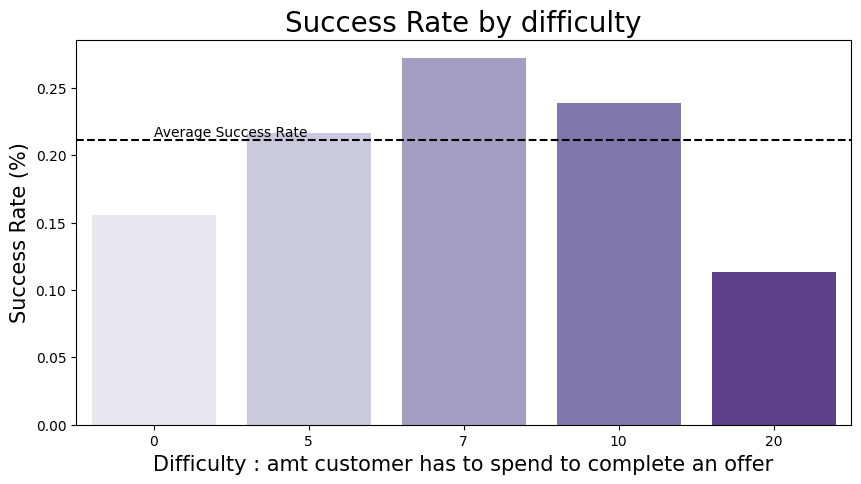

In [65]:
visualize_success_probability(dataframe=dataframe_analy, category='difficulty', category_label='difficulty'
                              , x_label='Difficulty : Amt customer has to spend to complete an offer')

/tmp/ipykernel_113/4017035685.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=category, y='Success Rate', data=success_rates, palette=color_scheme)


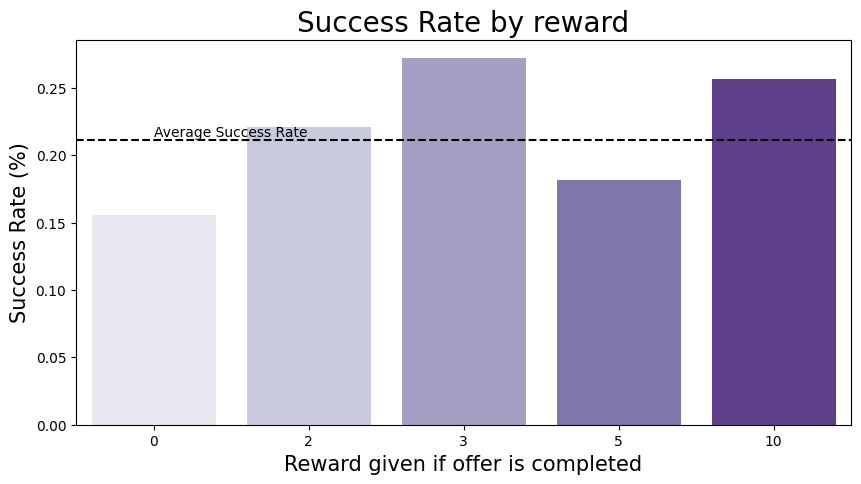

In [66]:
visualize_success_probability(dataframe=dataframe_analy, category='reward', category_label='reward', x_label='Reward given if offer is completed')

# 4. Machine Learning

## 4.1 Balancing the data by oversampling minority class

<Axes: title={'center': 'Successful offers'}, ylabel='count'>

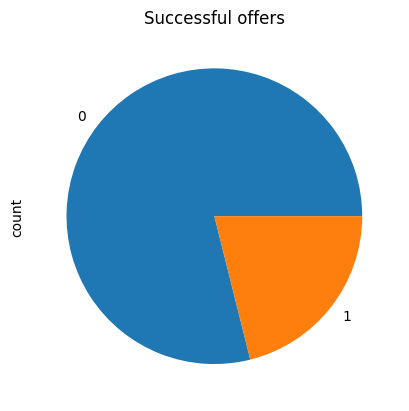

In [67]:
# Initial data
X = dataframe_final.drop(['successful_offer'], axis=1)
y = dataframe_final['successful_offer'].astype(int)

y.value_counts().plot(kind='pie', title='Successful offers')

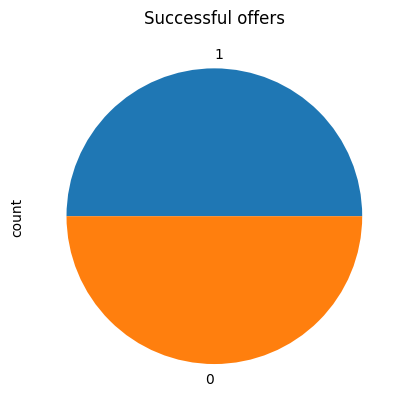

In [68]:
# Combining features and target 
dataframe_11 = pd.concat([pd.DataFrame(X), pd.Series(y, name='target')], axis=1)

# Separation of majority class and minority class
majority_class = dataframe_11['target'].value_counts().idxmax()
minority_class = dataframe_11['target'].value_counts().idxmin()
df_majority = dataframe_11[dataframe_11['target'] == majority_class]
df_minority = dataframe_11[dataframe_11['target'] == minority_class]

# Oversampling of the minority class
df_minority_oversampled = df_minority.sample(len(df_majority), replace=True, random_state=42)

# Combining the data and shuffling it
df_balanced = pd.concat([df_majority, df_minority_oversampled])
df_balanced_final = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# New x and y dataframe
X_new = df_balanced_final.drop('target', axis=1).values
y_new = df_balanced_final['target'].values

# Checking distribution again
pd.Series(y_new).value_counts().plot(kind='pie', title='Successful offers');

## 4.2 Creating training and testing data

In [69]:
random_state = 42
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.20, random_state=random_state)

In [70]:
X_train

array([[27, 70000.0, 0, ..., False, False, True],
       [45, 74000.0, 1, ..., True, False, False],
       [30, 54000.0, 0, ..., False, False, True],
       ...,
       [77, 43000.0, 6, ..., True, False, False],
       [50, 68000.0, 3, ..., False, True, False],
       [26, 33000.0, 3, ..., True, False, False]], dtype=object)

In [71]:
X_test

array([[61, 31000.0, 3, ..., True, False, False],
       [67, 86000.0, 1, ..., True, False, False],
       [32, 62000.0, 4, ..., True, False, False],
       ...,
       [26, 38000.0, 4, ..., False, True, False],
       [45, 64000.0, 0, ..., False, False, True],
       [66, 55000.0, 5, ..., True, False, False]], dtype=object)

In [72]:
y_train

array([1, 1, 0, ..., 1, 0, 0])

In [73]:
y_test

array([1, 1, 0, ..., 1, 1, 1])

## 4.3 Model evaluation

In [74]:
def model_evaluation1(model, X_train, X_test, y_train, y_test):
    """Train a machine learning model and evaluate it on training and test data."""
    
    # Training the model
    starting_time = tim()
    model.fit(X_train, y_train)
    ending_time = tim()
    elapsed_time = ending_time - starting_time

    print(f'Training completed in {elapsed_time:.2f} seconds.')

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Model performance
    metrics = {
        'Accuracy': {
            'Train': accuracy_score(y_train, y_train_pred),
            'Test': accuracy_score(y_test, y_test_pred),
        },
        'Recall': {
            'Train': recall_score(y_train, y_train_pred),
            'Test': recall_score(y_test, y_test_pred),
        },
        'Precision': {
            'Train': precision_score(y_train, y_train_pred),
            'Test': precision_score(y_test, y_test_pred),
        }
    }

    # Print results
    for metric_name, scores in metrics.items():
        print(f'\n{metric_name} metrics:')
        for dataset, score in scores.items():
            print(f'    {dataset} {metric_name.lower()}: {score:.4f}')
    
    return model


### 4.3.1 Logistic Regression

In [75]:
log_regr = LogisticRegression(random_state=random_state, solver='liblinear');
model_evaluation1(log_regr, X_train, X_test, y_train, y_test);

Training completed in 0.85 seconds.

Accuracy metrics:
    Train accuracy: 0.5923
    Test accuracy: 0.5907

Recall metrics:
    Train recall: 0.6728
    Test recall: 0.6710

Precision metrics:
    Train precision: 0.5792
    Test precision: 0.5794


### 4.3.2 Decision Tree

In [76]:
deci_tree = DecisionTreeClassifier(random_state=random_state);
model_evaluation1(deci_tree, X_train, X_test, y_train, y_test);

Training completed in 0.48 seconds.

Accuracy metrics:
    Train accuracy: 0.9439
    Test accuracy: 0.7948

Recall metrics:
    Train recall: 0.9822
    Test recall: 0.9092

Precision metrics:
    Train precision: 0.9122
    Test precision: 0.7406


### 4.3.3 Random Forest

In [77]:
rndm_forest = RandomForestClassifier(random_state=random_state, n_estimators=100);
model_evaluation1(rndm_forest, X_train, X_test, y_train, y_test);

Training completed in 7.21 seconds.

Accuracy metrics:
    Train accuracy: 0.9439
    Test accuracy: 0.8283

Recall metrics:
    Train recall: 0.9876
    Test recall: 0.9235

Precision metrics:
    Train precision: 0.9081
    Test precision: 0.7764


### 4.3.4 XGBoost Classifier

In [78]:
xg_boost = XGBClassifier();
model_evaluation1(xg_boost, X_train, X_test, y_train, y_test);

Training completed in 1.13 seconds.

Accuracy metrics:
    Train accuracy: 0.6933
    Test accuracy: 0.6455

Recall metrics:
    Train recall: 0.7605
    Test recall: 0.7137

Precision metrics:
    Train precision: 0.6701
    Test precision: 0.6292


### 4.3.5 Gradient Boosting Classifier

In [79]:
grad_boost = GradientBoostingClassifier(random_state=random_state);
model_evaluation1(grad_boost, X_train, X_test, y_train, y_test);

Training completed in 7.46 seconds.

Accuracy metrics:
    Train accuracy: 0.6026
    Test accuracy: 0.6014

Recall metrics:
    Train recall: 0.6902
    Test recall: 0.6888

Precision metrics:
    Train precision: 0.5870
    Test precision: 0.5875


# 4.4 Hyperparameters Tuning

In [80]:
parameters = {'max_depth': [1, 2, 3, 5, 7, 9, 15, 20, 25],
              'min_samples_split':[2, 3, 5, 7, 9, 15],
              'n_jobs' : [-1],
              'min_samples_leaf': [1, 3, 5, 7],
              'n_estimators': [50, 60, 70, 100, 200, 400], 
              'random_state': [random_state]
             }

In [81]:
random_search_cv = RandomizedSearchCV(
    rndm_forest,
    param_distributions=parameters,
    n_iter=30, 
    scoring='roc_auc',
    cv=3,
    random_state=random_state,
    n_jobs=-1
)


model_new = model_evaluation1(random_search_cv, X_train, X_test, y_train, y_test);

Training completed in 357.13 seconds.

Accuracy metrics:
    Train accuracy: 0.9416
    Test accuracy: 0.8220

Recall metrics:
    Train recall: 0.9834
    Test recall: 0.9116

Precision metrics:
    Train precision: 0.9074
    Test precision: 0.7738


In [82]:
model_performing_model = model_new.best_estimator_
model_performing_model

RandomForestClassifier(max_depth=25, min_samples_split=3, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [83]:
feature_importances = model_performing_model.feature_importances_

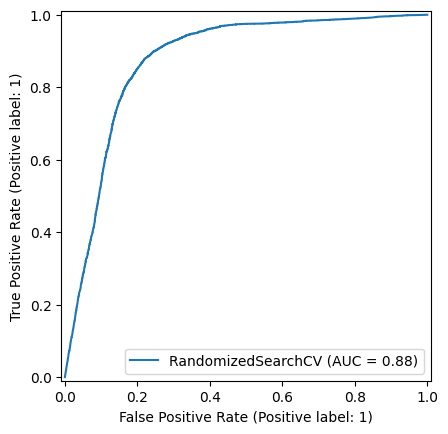

In [84]:
#ROC curve
metrics.RocCurveDisplay.from_estimator(estimator=model_new, 
                               X=X_test, 
                               y=y_test); 
plt.show()

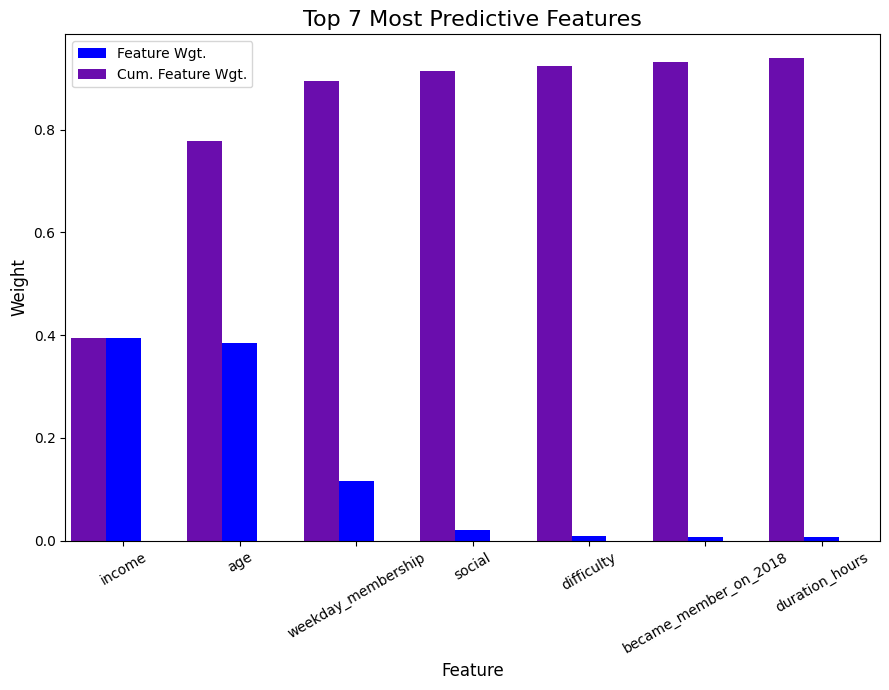

In [86]:
# Number of top features to display
n_features = 7

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Select top features and their importances
top_features = X.columns.values[sorted_indices[:n_features]]
top_importances = feature_importances[sorted_indices[:n_features]]

# Plot setup
plt.figure(figsize=(9, 7))
plt.title("Top 7 Most Predictive Features", fontsize=16)

# Plot individual feature weights
plt.bar(
    np.arange(n_features),
    top_importances,
    width=0.3,
    align="center",
    color='blue',
    label="Feature Wgt."
)

# Plot cumulative weights
plt.bar(
    np.arange(n_features) - 0.3,
    np.cumsum(top_importances),
    width=0.3,
    align="center",
    color='#6A0DAD',
    label="Cum. Feature Wgt."
)

# Axis labels and ticks
plt.xticks(np.arange(n_features), top_features, rotation=30)
plt.xlim(-0.5, n_features - 0.5)
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Weight", fontsize=12)

# Add legend and layout adjustments
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [87]:
#Save the model as a pickle file.

path1 = 'models/trained_classifier_model.pkl'

with open(path1, 'wb') as pickle_model:
    pickle.dump(model_new, pickle_model)

In [88]:
#Load trained machine learning model

with open(path1, 'rb') as pickle_model:
    
    model2 = pickle.load(pickle_model)
    
pickle_model.close()